## Summary
This is the training pipeline for a simple arcface densenet model. This model was also proposed in our [RANZCR 2nd place solution](https://www.kaggle.com/c/ranzcr-clip-catheter-line-classification/discussion/227407) for image retrieval; it did extremely well on matching. The model arch is implemented by my ex teammate [sheep](https://www.kaggle.com/steamedsheep). I want to try this in shopee competition as well. With no parameter tuning, I was able to get 0.653 on the public leaderboard with a CV around 0.732 with a proper validation scheme as I proposed in this notebook. Don't hesitate if you have any questions; answering your questions can help me learn as well. 

<img src="https://i.ibb.co/xSbhXwd/pipeline-shopee.png" alt="pipeline-shopee" border="0">

Inference notebook: https://www.kaggle.com/underwearfitting/pytorch-densenet-arcface-validation-inference

## Imports

In [1]:
!pip install efficientnet_pytorch


In [2]:
import pandas as pd
import numpy as np
import sys

package_paths = [
    '../input/timm-pytorch-image-models/pytorch-image-models-master', #'../input/efficientnet-pytorch-07/efficientnet_pytorch-0.7.0'
    '../input/image-fmix/FMix-master'
]
for pth in package_paths:
    sys.path.append(pth)
    
import os    
from fmix import sample_mask, make_low_freq_image, binarise_mask
import time
import cv2
import PIL.Image
import random
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import albumentations
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import gc
from sklearn.metrics import roc_auc_score
%matplotlib inline
import seaborn as sns
from pylab import rcParams
import timm
from warnings import filterwarnings
from sklearn.preprocessing import LabelEncoder
import math
import glob
from sklearn.model_selection import StratifiedKFold, GroupKFold
filterwarnings("ignore")

device = torch.device('cuda')

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False # set True to be faster
    print(f'Setting all seeds to be {seed} to reproduce...')
seed_everything(42)

Setting all seeds to be 42 to reproduce...


## Configuration

In [4]:
image_size = 512
batch_size = 8
n_worker = 4
init_lr = 3e-4
n_epochs = 30 # from my experiments, use > 25 when margin = 0.5
fold_id = 0
holdout_id = 0
valid_every = 5
save_after = 10
margin = 0.5 # 0 for faster convergence, larger may be beneficial
search_space = np.arange(40, 100, 10) # in my experiments, thresholds should be between 40 - 90 (/100) for cosine similarity
use_amp = False # todo: figure how to work with pytorch native amp
debug = True # set this to False to train in full
kernel_type = 'baseline'
model_dir = './weights/'
data_dir = '../input/shopee-product-matching/train_images/'
! mkdir $model_dir

mkdir: cannot create directory ‘./weights/’: File exists


## Make Folds

In [5]:
# df_trainx = pd.read_csv('../input/shopee-product-matching/train.csv')
# df_trainx['file_path'] = df_trainx.image.apply(lambda x: os.path.join(data_dir, x))
# df_trainx.head(5)

In [6]:
# gkf = GroupKFold(n_splits=5)
# df_trainx['fold'] = -1
# for fold, (train_idx, valid_idx) in enumerate(gkf.split(df_trainx, None, df_trainx.label_group)):
#     df_trainx.loc[valid_idx, 'fold'] = fold
df_train = pd.read_csv('../input/shopeefolds/train_folds.csv')
df_train['file_path'] = df_train.image.apply(lambda x: os.path.join(data_dir, x))

In [7]:
# le = LabelEncoder()
# df_trainx.label_group = le.fit_transform(df_trainx.label_group)

# display(df_trainx)

display(df_train)

,posting_id,image,image_phash,title,label_group,file_path,group,fold
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,../input/shopee-product-matching/train_images/...,1475,2
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,../input/shopee-product-matching/train_images/...,4395,2
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,../input/shopee-product-matching/train_images/...,6202,0
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,../input/shopee-product-matching/train_images/...,409,0
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,../input/shopee-product-matching/train_images/...,3063,3
...,...,...,...,...,...,...,...,...
34245,train_4028265689,fff1c07ceefc2c970a7964cfb81981c5.jpg,e3cd72389f248f21,Masker Bahan Kain Spunbond Non Woven 75 gsm 3 ...,3776555725,../input/shopee-product-matching/train_images/...,8933,2
34246,train_769054909,fff401691371bdcb382a0d9075dfea6a.jpg,be86851f72e2853c,MamyPoko Pants Royal Soft - S 70 - Popok Celana,2736479533,../input/shopee-product-matching/train_images/...,7237,0
34247,train_614977732,fff421b78fa7284284724baf249f522e.jpg,ad27f0d08c0fcbf0,KHANZAACC Robot RE101S 1.2mm Subwoofer Bass Me...,4101248785,../input/shopee-product-matching/train_images/...,3890,2
34248,train_3630949769,fff51b87916dbfb6d0f8faa01bee67b8.jpg,e3b13bd1d896c05c,"Kaldu NON MSG HALAL Mama Kamu Ayam Kampung , S...",1663538013,../input/shopee-product-matching/train_images/...,9304,1


## Transforms

In [8]:
# def transforms_train():
#     return albumentations.Compose([
#        albumentations.RandomResizedCrop(CFG['image_size'], CFG['image_size'], scale=(0.9, 1), p=1), 
#        albumentations.HorizontalFlip(p=0.5),
#        albumentations.ShiftScaleRotate(p=0.5),
#        albumentations.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.7),
#        albumentations.RandomBrightnessContrast(brightness_limit=(-0.2,0.2), contrast_limit=(-0.2, 0.2), p=0.7),
#        albumentations.CLAHE(clip_limit=(1,4), p=0.5),
#        albumentations.OneOf([
#            albumentations.OpticalDistortion(distort_limit=1.0),
# #            albumentations.GridDistortion(num_steps=5, distort_limit=1.),
# #            albumentations.ElasticTransform(alpha=3),
#        ], p=0.2),
# #        albumentations.OneOf([
# #            albumentations.GaussNoise(var_limit=[10, 50]),
# #            albumentations.GaussianBlur(),
# #            albumentations.MotionBlur(),
# #            albumentations.MedianBlur(),
# #        ], p=0.2),
#       albumentations.Resize(CFG['image_size'], CFG['image_size']),
# #       albumentations.OneOf([
# #           JpegCompression(),
# #           Downscale(scale_min=0.1, scale_max=0.15),
# #       ], p=0.2),
#       IAAPiecewiseAffine(p=0.2),
#       IAASharpen(p=0.2),
# #       albumentations.Cutout(p=0.5),
#       albumentations.Cutout(max_h_size=int(CFG['image_size'] * 0.1), max_w_size=int(CFG['image_size'] * 0.1), num_holes=5, p=0.5),
#       albumentations.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
#     ])

def transforms_train():
    return albumentations.Compose([
        albumentations.Resize(image_size, image_size),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.RandomBrightnessContrast(p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2)),
        albumentations.HueSaturationValue(p=0.5, hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2),
        albumentations.ShiftScaleRotate(p=0.5, shift_limit=0.0625, scale_limit=0.2, rotate_limit=20),
        albumentations.CoarseDropout(p=0.5),
        albumentations.Normalize()
])

# transforms_train = albumentations.Compose([
#     albumentations.Resize(image_size, image_size),
#     albumentations.HorizontalFlip(p=0.5),
#     albumentations.RandomBrightnessContrast(p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2)),
#     albumentations.HueSaturationValue(p=0.5, hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2),
#     albumentations.ShiftScaleRotate(p=0.5, shift_limit=0.0625, scale_limit=0.2, rotate_limit=20),
#     albumentations.CoarseDropout(p=0.5),
#     albumentations.Normalize()
# ])

# transforms_valid = albumentations.Compose([
#     albumentations.Resize(image_size, image_size),
#     albumentations.Normalize()
# ])
def transforms_valid():
    return albumentations.Compose([
        albumentations.Resize(image_size, image_size),
        albumentations.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
    ])

## Dataset

In [9]:
def rand_bbox(size, lam):
    W = size[0]
    H = size[1]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

class SHOPEEDataset(Dataset):
    def __init__(self, df, mode, transform=None, do_fmix=False, 
                 fmix_params={'alpha': 1.,
                              'decay_power': 3.,
                              'shape': (image_size, image_size),
                              'max_soft': True,
                              'reformulate': False
                },do_cutmix=False,
                 cutmix_params={
                    'alpha': 1,
                }):
        
        self.df = df.reset_index(drop=True)
        self.mode = mode
        self.transform = transform
        self.do_fmix = do_fmix
        self.fmix_params = fmix_params
        self.do_cutmix = do_cutmix
        self.cutmix_params = cutmix_params
        self.labels = df.group.values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        label = self.labels[index]
        
        row = self.df.loc[index]
        img = cv2.imread(row.file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        
        if self.transform is not None:
            img = self.transform(image=img)['image']
            
        if self.do_fmix and np.random.uniform(0., 1., size=1)[0] > 0.5:
#             with torch.no_grad:
            lam = np.clip(np.random.beta(self.fmix_params['alpha'], self.fmix_params['alpha']), 0.6, 0.7)
            #Make mask, et mean/ std
            mask = make_low_freq_image(self.fmix_params['decay_power'], self.fmix_params['shape'])
            
            mask = binarise_mask(mask, lam, self.fmix_params['shape'], self.fmix_params['max_soft'])
#             print(self.df.index)
            fmix_ix = np.random.choice(self.df.index, size=1)[0]
#             print("==============Starts now===============")
            row = self.df.iloc[fmix_ix]
#             print(row)
            fmix_img = cv2.imread(row.file_path)
# #             print(fmix_img)
            fmix_img = cv2.cvtColor(fmix_img,cv2.COLOR_BGR2RGB)
            

            if self.transform is not None:
                fmix_img = self.transform(image=fmix_img)['image']
            
#             print("Mask shape: ", mask.shape)
#             mask_torch = mask.numpy()
            mask = mask.transpose(1,2,0)
#             print("Transposed mask torch:", mask.shape)
            mask_torch = mask
#             mask_torch = torch.from_numpy(mask)
            
#             print("Mask torch shape: ", mask_torch.shape)
            #mix image
            img = mask_torch*img+(1.-mask_torch)*fmix_img
#             print("Mix shape:", img.shape)
            rate = mask.sum()/image_size/image_size
            label = rate*label + (1.-rate)*self.labels[fmix_ix]
        
        if self.do_cutmix and np.random.uniform(0., 1., size=1)[0] > 0.5:
            #print(img.sum(), img.shape)
            with torch.no_grad():
                cmix_ix = np.random.choice(self.df.index, size=1)[0]
                
                row = self.df.iloc[cmix_ix]
                cmix_img = cv2.imread(row.file_path)
                cmix_img = cv2.cvtColor(cmix_img,cv2.COLOR_BGR2RGB)
                
                if self.transform:
                    cmix_img = self.transform(image=cmix_img)['image']
                    
                lam = np.clip(np.random.beta(self.cutmix_params['alpha'], self.cutmix_params['alpha']),0.3,0.4)
                bbx1, bby1, bbx2, bby2 = rand_bbox((image_size, image_size), lam)

                img[:, bbx1:bbx2, bby1:bby2] = cmix_img[:, bbx1:bbx2, bby1:bby2]

                rate = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (image_size * image_size))
                label = rate*label + (1.-rate)*self.labels[cmix_ix]
                
        img = img.astype(np.float32)
        img = img.transpose(2,0,1)
        
        if self.mode == 'test':
            return torch.tensor(img).float()
        else:
            return torch.tensor(img).float(), torch.tensor(row.group).float()

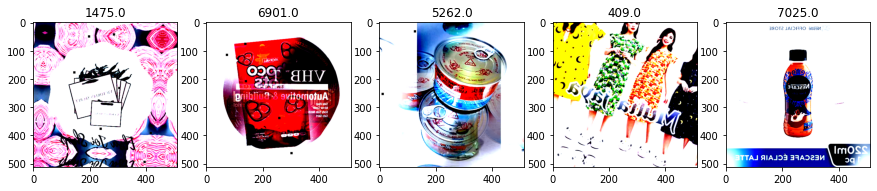

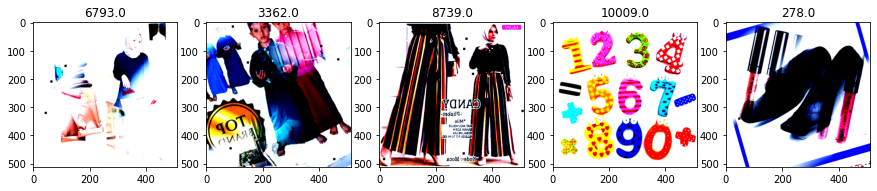

In [10]:
dataset = SHOPEEDataset(df_train,'train', transform = transforms_train(), do_fmix=True, do_cutmix=False)
rcParams['figure.figsize'] = 15,5
for i in range(2):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = i*5 + p
        img, label = dataset[idx]
        axarr[p].imshow(img.transpose(0,1).transpose(1,2).squeeze())
        axarr[p].set_title(label.item())

## Model

In [11]:
class ArcModule(nn.Module):
    def __init__(self, in_features, out_features, s = 10, m = margin):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_normal_(self.weight)

        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = torch.tensor(math.cos(math.pi - m))
        self.mm = torch.tensor(math.sin(math.pi - m) * m)

    def forward(self, inputs, labels):
        cos_th = F.linear(inputs, F.normalize(self.weight))
        cos_th = cos_th.clamp(-1, 1)
        sin_th = torch.sqrt(1.0 - torch.pow(cos_th, 2))
        cos_th_m = cos_th * self.cos_m - sin_th * self.sin_m
        # print(type(cos_th), type(self.th), type(cos_th_m), type(self.mm))
        cos_th_m = torch.where(cos_th > self.th, cos_th_m, cos_th - self.mm)

        cond_v = cos_th - self.th
        cond = cond_v <= 0
        cos_th_m[cond] = (cos_th - self.mm)[cond]

        if labels.dim() == 1:
            labels = labels.unsqueeze(-1)
        onehot = torch.zeros(cos_th.size()).cuda()
        labels = labels.type(torch.LongTensor).cuda()
        onehot.scatter_(1, labels, 1.0)
        outputs = onehot * cos_th_m + (1.0 - onehot) * cos_th
        outputs = outputs * self.s
        return outputs

In [12]:
class SHOPPEEefficientnetb3(nn.Module):

    def __init__(self, channel_size, out_feature, dropout=0.5, backbone='tf_efficientnet_b3_ns', pretrained=True):
        super(SHOPPEEefficientnetb3, self).__init__()
        self.backbone = timm.create_model(backbone, pretrained=pretrained)
        self.channel_size = channel_size
        self.out_feature = out_feature
        self.in_features = self.backbone.classifier.in_features
        self.margin = ArcModule(in_features=self.channel_size, out_features = self.out_feature)
        self.bn1 = nn.BatchNorm2d(self.in_features)
        self.dropout = nn.Dropout2d(dropout, inplace=True)
        self.fc1 = nn.Linear(self.in_features * 16 * 16 , self.channel_size)
        self.bn2 = nn.BatchNorm1d(self.channel_size)
        
    def forward(self, x, labels=None):
        features = self.backbone.forward_features(x)
        features = self.bn1(features)
        features = self.dropout(features)
        features = features.view(features.size(0), -1)
        features = self.fc1(features)
        features = self.bn2(features)
        features = F.normalize(features)
        if labels is not None:
            return self.margin(features, labels)
        return features

In [13]:
model = SHOPPEEefficientnetb3(512, df_train.label_group.nunique())
model.to(device);

## Utils

In [14]:
def train_func(train_loader):
    model.train()
    bar = tqdm(train_loader)
    if use_amp:
        scaler = torch.cuda.amp.GradScaler()
    losses = []
    for batch_idx, (images, targets) in enumerate(bar):

        images, targets = images.to(device), targets.to(device).long()
        
        if debug and batch_idx == 100:
            print('Debug Mode. Only train on first 100 batches.')
            break
            
        if use_amp:
            with torch.cuda.amp.autocast():
                logits = model(images, targets)
                loss = criterion(logits, targets)
            scaler.scale(loss).backward()
            if ((batch_idx + 1) %  accumulation_step == 0) or ((batch_idx + 1) == len(train_loader)):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
        else:
            logits = model(images, targets)
            loss = criterion(logits, targets)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        losses.append(loss.item())
        smooth_loss = np.mean(losses[-30:])

        bar.set_description(f'loss: {loss.item():.5f}, smth: {smooth_loss:.5f}')

    loss_train = np.mean(losses)
    return loss_train


def valid_func(valid_loader):
    model.eval()
    bar = tqdm(valid_loader)

    PROB = []
    TARGETS = []
    losses = []
    PREDS = []

    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(bar):

            images, targets = images.to(device), targets.to(device).long()

            logits = model(images, targets)

            PREDS += [torch.argmax(logits, 1).detach().cpu()]
            TARGETS += [targets.detach().cpu()]

            loss = criterion(logits, targets)
            losses.append(loss.item())
           
            bar.set_description(f'loss: {loss.item():.5f}')

    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
    accuracy = (PREDS==TARGETS).mean()
   
    loss_valid = np.mean(losses)
    return loss_valid, accuracy

def generate_test_features(test_loader):
    model.eval()
    bar = tqdm(test_loader)
    
    FEAS = []
    TARGETS = []

    with torch.no_grad():
        for batch_idx, (images) in enumerate(bar):

            images = images.to(device)

            features = model(images)

            FEAS += [features.detach().cpu()]

    FEAS = torch.cat(FEAS).cpu().numpy()
    
    return FEAS

In [15]:
def row_wise_f1_score(labels, preds):
    scores = []
    for label, pred in zip(labels, preds):
        n = len(np.intersect1d(label, pred))
        score = 2 * n / (len(label)+len(pred))
        scores.append(score)
    return scores, np.mean(scores)

In [16]:
def find_threshold(df, lower_count_thresh, upper_count_thresh, search_space):
    '''
    Compute the optimal threshold for the given count threshold.
    '''
    score_by_threshold = []
    best_score = 0
    best_threshold = -1
    for i in tqdm(search_space):
        sim_thresh = i/100
        selection = ((FEAS@FEAS.T) > sim_thresh).cpu().numpy()
        matches = []
        oof = []
        for row in selection:
            oof.append(df.iloc[row].posting_id.tolist())
            matches.append(' '.join(df.iloc[row].posting_id.tolist()))
        tmp = df.groupby('label_group').posting_id.agg('unique').to_dict()
        df['target'] = df.label_group.map(tmp)
        scores, score = row_wise_f1_score(df.target, oof)
        df['score'] = scores
        df['oof'] = oof
        
        selected_score = df.query(f'count > {lower_count_thresh} and count < {upper_count_thresh}').score.mean()
        score_by_threshold.append(selected_score)
        if selected_score > best_score:
            best_score = selected_score
            best_threshold = i
            
    plt.title(f'Threshold Finder for count in [{lower_count_thresh},{upper_count_thresh}].')
    plt.plot(score_by_threshold)
    plt.axis('off')
    plt.show()
    print(f'Best score is {best_score} and best threshold is {best_threshold/100}')

## Train

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = init_lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)

In [18]:
df_train_this = df_train[df_train['fold'] != fold_id]
df_valid_this = df_train[df_train['fold'] == fold_id]

df_valid_this['count'] = df_valid_this.label_group.map(df_valid_this.label_group.value_counts().to_dict())

# dataset = SHOPEEDataset(df_train, data_dir,'train', transform = transforms_train(), do_fmix=True, do_cutmix=False)

dataset_train = SHOPEEDataset(df_train_this, 'train', transform = transforms_train(), do_fmix=True, do_cutmix=False)
dataset_valid = SHOPEEDataset(df_valid_this, 'test', transform = transforms_valid())

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers = n_worker)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers = n_worker)

In [19]:
for epoch in range(n_epochs):
    scheduler.step()
    loss_train = train_func(train_loader)
    if epoch % valid_every == 0: 
        print('Now generating features for the validation set to simulate the submission.')
        FEAS = generate_test_features(valid_loader)
        FEAS = torch.tensor(FEAS).cuda()
        print('Finding Best Threshold in the given search space.')
        find_threshold(df = df_valid_this, 
               lower_count_thresh = 0, 
               upper_count_thresh = 999,
               search_space = search_space)
        if epoch >= save_after:
            torch.save(model.state_dict(), f'{model_dir}{kernel_type}_fold{fold_id}_efficientnetb3_{image_size}_epoch{epoch}.pth')

  0%|          | 0/3425 [00:00<?, ?it/s]

KeyboardInterrupt: 